## Modeling
### Experiments with Tree-based Scikit-learn models

**Objective**: The primary objective of this notebook is to perform experimentation with the tree-based models for multi-step ahead forecasting.



In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Use __file__ for portability

# Move up one level to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Change working directory
os.chdir(project_root)

# Verify the change
print(os.getcwd()) 

/home/michel/projects/tree-based-forecasting-boilerplate


In [2]:
%load_ext autoreload
%autoreload 2

from scripts.run_wfv import *
from src.models.train_model import *
from src.models.evaluate_model import *
from src.models.predict_model import *
from src.visualization.data_viz import *

In [3]:
logger.setLevel("WARNING")

In [4]:
models_list = model_config["available_models"]
ticker_list = data_config["ticker_list"]

In [129]:
def walk_forward_validation(load_best_params, models_list, ticker_list, wfv_steps=0, wfv_size=FORECAST_HORIZON, write_to_table=True) -> pd.DataFrame:
    """
    Performs Walk Forward Validation (WFV) for your forecasting models.

    WFV involves iteratively training and testing models on expanding time windows to simulate real-world forecasting scenarios.
    This function evaluates the performance of specified models on multiple time frames for given stock tickers.

    Args:
        load_best_params (bool): If True, loads saved best model parameters; otherwise, uses default parameters.
        models_list (list): List of model types to evaluate (e.g., ["LinearRegression", "RandomForest"]).
        ticker_list (list): List of stock ticker symbols for validation.
        wfv_steps (int, optional): Number of validation steps (windows). Defaults to 0.
        wfv_size (int, optional): Size of each validation window (in days). Defaults to FORECAST_HORIZON.
        write_to_table (bool, optional): If True, writes results to a CSV file. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing detailed validation results for each model, ticker, and window, including predictions, actual values, calculated metrics, and metadata.

    Process:
        1. Loads featurized dataset.
        2. Iterates through each ticker symbol in `ticker_list`.
        3. Iterates through each model type in `models_list`.
        4. Calculates the start date for WFV based on `wfv_steps` and `wfv_size`.
        5. Performs `wfv_steps` iterations:
            a. Filters data up to the current window's end date.
            b. Calls `stepwise_prediction` to train the model and generate predictions.
            c. Calculates performance metrics (e.g., using `calculate_metrics`).
            d. Appends results to `validation_report_df` with metadata.
            e. Expands the training data window for the next step.
        6. (Optional) Appends results to a CSV file if `write_to_table` is True. 
    """

    validation_report_df = pd.DataFrame()

    logger.debug("Loading the featurized dataset..")
    feature_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, PROCESSED_DATA_NAME), parse_dates=["DATE"])


    for ticker in ticker_list:
        filtered_feature_df = feature_df[feature_df[CATEGORY_COL] == ticker].copy().drop(CATEGORY_COL, axis=1)
        
        for model_type in models_list:
            logger.info(f"Performing model cross validation for ticker symbol [{ticker}] using model [{model_type}]...")

            wfv_start_date = filtered_feature_df["DATE"].max() - relativedelta(days=wfv_size*wfv_steps)
            step_df = filtered_feature_df[filtered_feature_df["DATE"] <= wfv_start_date].copy()

            logger.info(f"WFV with {wfv_steps} steps and step size equal to {wfv_size}...")
            logger.info(f"Start training date: {step_df['DATE'].max()}")

            for step in range(wfv_steps+1):
                logger.info(f"Iteration [{step}] training date: {step_df['DATE'].max()}")

                predictions_df, X_testing_df = stepwise_prediction(
                    X=step_df.drop(columns=[TARGET_COL]),
                    y=step_df[TARGET_COL],
                    forecast_horizon=FORECAST_HORIZON,
                    model_type=model_type,
                    ticker=ticker,
                    load_best_params=load_best_params
                )

                predictions_df[CATEGORY_COL] = ticker
                predictions_df = calculate_metrics(predictions_df, "ACTUAL", PREDICTED_COL)
                predictions_df["CLASS"] = "Testing"
                predictions_df["TRAINING_DATE"] = dt.datetime.today().date()
                predictions_df["WINDOW"] = step
                validation_report_df = pd.concat([validation_report_df, predictions_df], axis=0)

                # Add the previous testing dates to the training dataset
                step_df = filtered_feature_df[filtered_feature_df["DATE"] <= (wfv_start_date + relativedelta(days=wfv_size * (step + 1)))].copy()

    
    if write_to_table:
        logger.info("Writing the testing results dataframe...")
        file_path = os.path.join(OUTPUT_DATA_PATH, 'default_wfv_'+CROSS_VAL_DATA_NAME)

        if os.path.isfile(file_path):
            validation_report_df.to_csv(file_path, mode='a', header=False, index=False)
        else:
            validation_report_df.to_csv(file_path, index=False)

    return validation_report_df

In [120]:
def update_test_values(X: pd.DataFrame, y: pd.Series, day: int) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepares the feature and target data for testing on a specific day.

    This function extracts a single row (or the remaining rows if it's the last day) 
    from the input feature DataFrame (X) and target Series (y) to create a test set for 
    a specific day. The day is specified relative to the end of the DataFrame, where
    day 1 represents the last day, day 2 the second-to-last day, and so on.

    Args:
        X (pd.DataFrame): The feature DataFrame containing all historical data.
        y (pd.Series): The target Series containing all historical target values.
        day (int): The day to extract for testing, relative to the end of the DataFrames.
                   1 is the last day, 2 is the second-to-last, etc.

    Returns:
        tuple[pd.DataFrame, pd.Series]: A tuple containing:
            - X_test (pd.DataFrame): A DataFrame with the features for the specified day.
            - y_test (pd.Series): A Series with the target value for the specified day.

    Raises:
        IndexError: If the specified `day` is out of bounds for the input DataFrames.
    """
    if day != 1:
        # Select a single row using negative indexing
        X_test = X.iloc[-day:-day+1,:]
        y_test = y.iloc[-day:-day+1]

    else:
        # Handle the special case of the last day (day 1)
        X_test = X.iloc[-day:,:]
        y_test = y.iloc[-day:]

    X_test.reset_index(drop=True, inplace=True)

    return X_test, y_test


def calculate_metrics(pred_df, actuals: str, predictions: str):
    logger.debug("Calculating the evaluation metrics...")
    
    model_mape = round(mean_absolute_percentage_error(pred_df[actuals], pred_df[predictions]), 4)
    model_rmse = round(root_mean_squared_error(pred_df[actuals], pred_df[predictions]), 2)
    model_mae = round(mean_absolute_error(pred_df[actuals], pred_df[predictions]), 2)
    model_wape = round((pred_df[actuals] - pred_df[predictions]).abs().sum() / pred_df[actuals].sum(), 2)
    bias = ((pred_df[predictions] - pred_df[actuals]) / (pred_df[predictions] + pred_df[actuals])).values.round(3)

    pred_df["MAPE"] = model_mape
    pred_df["RMSE"] = model_rmse
    pred_df["Bias"] = bias

    return pred_df


def stepwise_prediction(X: pd.DataFrame, y: pd.Series, forecast_horizon: int, model_type: Any, ticker: str, load_best_params: bool = False) -> pd.DataFrame:
    """
    Performs iterativly 1 step ahead forecast validation for a given model type and ticker symbol.

    This function iteratively trains a model on historical data, then forecasts into the future using a sliding window approach.
    The forecast horizon is adjusted to exclude weekends. It returns a DataFrame with the actual and predicted values, along with performance metrics.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        forecast_horizon (int): The number of days to forecast ahead.
        model_type (Any): The type of model to use (e.g., 'xgb', 'rf', 'et').
        ticker (str): The stock ticker symbol.
        load_best_params (bool): If True, loads saved best model parameters; otherwise, uses default parameters. Defaults to False.

    Returns:
        pd.DataFrame: A DataFrame containing:
            - DATE: The dates of the predictions.
            - ACTUAL: The actual target values.
            - PREDICTED_COL: The predicted values.
            - MODEL_TYPE: The type of model used.
            - CLASS: "Testing" (indicates the type of data).
            - Additional columns with performance metrics (MAE, RMSE, MAPE).
    """

    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []
    X_testing_df = pd.DataFrame()

    forecast_horizon = weekend_adj_forecast_horizon(forecast_horizon, 2)
    
    # get the one-shot training set
    X_train = X.iloc[:-forecast_horizon, :]
    y_train = y.iloc[:-forecast_horizon]
    final_y = y_train.copy()

    logger.debug(f"Training model until (including): {X_train["DATE"].max().date()}")

    best_model = train_model(
        X_train.drop(columns=["DATE"]),
        y_train,
        model_type,
        ticker,
        load_best_params,
    )

    # Predict on training to evaluate overfitting
    train_preds = best_model.predict(X_train.drop(columns=["DATE"]))
    train_mape = round(mean_absolute_percentage_error(y_train, train_preds), 4)
    train_rmse = round(np.sqrt(mean_squared_error(y_train, train_preds)), 2)

    # Plotting the Learning Results
    # if model_type == "XGB":
    #     learning_curves_fig, feat_imp = extract_learning_curves(best_model, display=False)

    for day in range(forecast_horizon, 0, -1):
        X_test, y_test = update_test_values(X, y, day)
        logger.debug(f"Testing Date: {X_test["DATE"].min().date()}")

        if len(predictions) != 0:

            X_test = update_lag_features(X_test, -1, list(final_y.values), X_test.columns)
            X_test = update_ma_features(X_test, -1, list(final_y.values), X_test.columns)

        prediction = best_model.predict(X_test.drop("DATE", axis=1))

        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["DATE"].max())

        final_y = pd.concat([final_y, pd.Series(prediction[0])], axis=0)
        final_y = final_y.reset_index(drop=True)
        X_testing_df = pd.concat([X_testing_df, X_test], axis=0)

    pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["DATE", "ACTUAL", PREDICTED_COL])

    pred_df["MODEL_TYPE"] = type(best_model).__name__
    pred_df["TRAINING_MAPE"] = train_mape
    pred_df["TRAINING_RMSE"] = train_rmse
    
    X_testing_df[PREDICTED_COL] = predictions
    X_testing_df.reset_index(drop=True, inplace=True)
    
    return pred_df, X_testing_df

In [121]:
def split_feat_df_Xy(df):
    """Splits the featurized dataframe to train the ML models."""
    X_train=df.drop([TARGET_COL, "DATE"], axis=1)
    y_train=df[TARGET_COL]

    return X_train, y_train


def train_model(X_train: pd.DataFrame, y_train: pd.Series, model_type: str, ticker_symbol: str, load_best_params=True) -> Any:
    """Trains a tree-based regression model (XGBoost or ExtraTrees).

    This function trains either an XGBoost or ExtraTreesRegressor model for a given ticker symbol.
    It can optionally tune the model hyperparameters using grid search and save the trained model to disk.

    Args:
        X_train (pandas.DataFrame or numpy.ndarray): The training feature data.
        y_train (pandas.Series or numpy.ndarray): The training target values.
        model_type (str): The type of model to train. Choose from 'XGB' (XGBoost) or 'ET' (ExtraTrees).
        ticker_symbol (str): The ticker symbol representing the time series being modeled.
        load_best_params (bool): If True, loads saved best model parameters; otherwise, uses default parameters. Defaults to True.

    Returns:
        The trained regression model object.
    """
    base_params = all_base_params[model_type]

    if load_best_params:
        best_params_path = os.path.join(MODELS_PATH, ticker_symbol, f"best_params_{model_type}.joblib") 
        best_params = joblib.load(best_params_path)
        base_params.update(best_params)

        if model_type == 'XGB':
            model = xgb.XGBRegressor(objective='reg:squarederror', **base_params, eval_metric=["rmse", "logloss"]) \
                .fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=20)
        elif model_type == 'ET':
            model = ExtraTreesRegressor(**base_params).fit(X_train, y_train)
        elif model_type == 'ADA':
            model = AdaBoostRegressor(**base_params).fit(X_train, y_train)
        else:
            raise ValueError("Model type not recognized! Check 'models_list' parameter in project_config.yaml.")
        
    else:
        if model_type == 'XGB':
            model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=["rmse", "logloss"]) \
                .fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=20)
        elif model_type == 'ET':
            model = ExtraTreesRegressor().fit(X_train, y_train)
        elif model_type == 'ADA':
            model = AdaBoostRegressor().fit(X_train, y_train)
        else:
            raise ValueError("Model type not recognized! Check 'models_list' parameter in project_config.yaml.")

    return model


def tune_params_gridsearch(X: pd.DataFrame, y: pd.Series, model_type: str, n_splits=2):
    """
    Performs time series hyperparameter tuning on a model using grid search.
    
    Args:
        X (pd.DataFrame): The input feature data
        y (pd.Series): The target values
        model_type (str): The model to tune. Options: ['XGB', 'ET', 'ADA']
        n_splits (int): Number of folds for cross-validation (default: 3)
    
    Returns:
        best_params (dict): The best hyperparameters found by the grid search
    """

    if model_type == 'XGB':
        model = xgb.XGBRegressor()
    elif model_type == 'ET':
        model = ExtraTreesRegressor()
    elif model_type == 'ADA':
        model = AdaBoostRegressor()
    else:
        raise ValueError("Model type not recognized! Check 'models_list' parameter in project_config.yaml.")

    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=FORECAST_HORIZON)
    param_distributions = all_param_distributions[model_type]

    grid_search = GridSearchCV(
        model,
        param_grid=param_distributions,
        cv=tscv,
        n_jobs=6,
        scoring=model_config['scoring_metric'],
        verbose=True,
        return_train_score=True
    ).fit(X, y)
  
    return grid_search


def select_and_stage_best_model(models: dict, X_test: pd.DataFrame, y_test: pd.Series, metric='rmse'):
    """
    Evaluates multiple models, selects the best based on a given metric, and stages it to "prod".

    Args:
        models (dict): A dictionary of models with their names as keys (e.g., {'XGB': xgb_model, 'ET': et_model, ...}).
        X_test (pd.DataFrame): Test feature matrix.
        y_test (pd.Series): Test target values.
        metric (str, optional): Evaluation metric ('rmse' or 'mae'). Defaults to 'rmse'.
    """
    results = {}

    # Evaluate each model
    for model_name, model in models.items():
        y_pred = model.predict(X_test)

        if metric == 'rmse':
            score = root_mean_squared_error(y_test, y_pred)
        else:
            raise ValueError(f"Invalid metric: {metric}. Choose 'rmse' or 'mae'.")

        results[model_name] = score

    # Select the best model
    logger.info(f"Model Selection Results:\n {results}")
    best_model_name = min(results, key=results.get)  # Get model with lowest error

    logger.info(f"\nBest Model: {best_model_name} with {metric.upper()}: {results[best_model_name]:.4f}")

    return best_model_name


In [130]:
validation_report_df = walk_forward_validation(
    load_best_params = True,
    models_list = models_list,
    ticker_list = ticker_list,
    wfv_steps = 1,#WFV_STEPS,
    wfv_size = FORECAST_HORIZON
)

[0]	validation_0-rmse:10.39100	validation_0-logloss:-4407.97249
[20]	validation_0-rmse:1.72765	validation_0-logloss:-4408.49537
[34]	validation_0-rmse:0.78825	validation_0-logloss:-4408.49779
[0]	validation_0-rmse:10.38197	validation_0-logloss:-4409.53401
[20]	validation_0-rmse:1.72183	validation_0-logloss:-4410.05650
[34]	validation_0-rmse:0.78372	validation_0-logloss:-4410.05861
[0]	validation_0-rmse:2.46721	validation_0-logloss:-82.70995
[20]	validation_0-rmse:0.31387	validation_0-logloss:-84.50305
[34]	validation_0-rmse:0.09262	validation_0-logloss:-85.14855
[0]	validation_0-rmse:2.47974	validation_0-logloss:-83.52301
[20]	validation_0-rmse:0.31567	validation_0-logloss:-85.34312
[34]	validation_0-rmse:0.09329	validation_0-logloss:-85.93634
[0]	validation_0-rmse:1.97136	validation_0-logloss:-325.76432
[20]	validation_0-rmse:0.26579	validation_0-logloss:-325.98442
[34]	validation_0-rmse:0.11379	validation_0-logloss:-325.98800
[0]	validation_0-rmse:1.97041	validation_0-logloss:-326.07

In [123]:
validation_report_df.sample(5)

,DATE,ACTUAL,FORECAST,MODEL_TYPE,TRAINING_MAPE,TRAINING_RMSE,TICKER,MAPE,RMSE,Bias,CLASS,TRAINING_DATE
2,2024-06-21,8.120,8.008979,ExtraTreesRegressor,0.0062,0.02,BCFF11.SA,0.0166,0.17,-0.007,Testing,2024-06-25
4,2024-06-18,116.120,118.128889,AdaBoostRegressor,0.0039,0.55,BOVA11.SA,0.0133,1.70,0.009,Testing,2024-06-25
3,2024-06-24,11.200,10.808260,AdaBoostRegressor,0.0212,0.28,BRSR6.SA,0.0271,0.31,-0.018,Testing,2024-06-25
0,2024-06-12,10.848,11.120641,XGBRegressor,0.0117,0.16,BRSR6.SA,0.0133,0.17,0.012,Testing,2024-06-25
3,2024-06-17,10.820,10.821092,AdaBoostRegressor,0.0207,0.27,BRSR6.SA,0.0032,0.05,0.000,Testing,2024-06-25


In [131]:
mean_metrics_by_model = validation_report_df.groupby(["TICKER", "MODEL_TYPE"], as_index=False).agg({
    "MAPE": "mean",
    "RMSE": "mean"
})

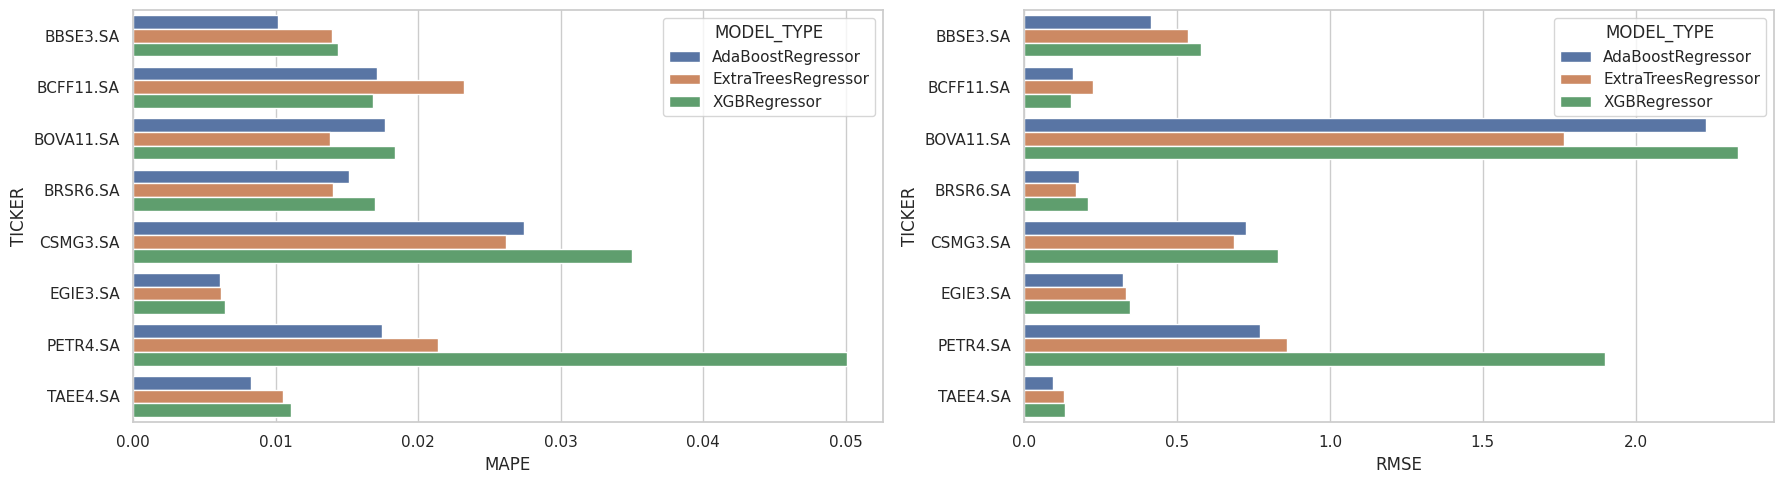

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.barplot(data = mean_metrics_by_model,
            x='MAPE',
            y='TICKER',
            hue='MODEL_TYPE',
            ax=axs[0])

sns.barplot(data = mean_metrics_by_model,
            x='RMSE',
            y='TICKER',
            hue='MODEL_TYPE',
            ax=axs[1])
plt.tight_layout()
plt.show()

In [133]:
mean_metrics_by_model

,TICKER,MODEL_TYPE,MAPE,RMSE
0,BBSE3.SA,AdaBoostRegressor,0.01020,0.415
1,BBSE3.SA,ExtraTreesRegressor,0.01395,0.535
2,BBSE3.SA,XGBRegressor,0.01435,0.580
3,BCFF11.SA,AdaBoostRegressor,0.01710,0.160
4,BCFF11.SA,ExtraTreesRegressor,0.02325,0.225
5,BCFF11.SA,XGBRegressor,0.01685,0.155
6,BOVA11.SA,AdaBoostRegressor,0.01765,2.230
7,BOVA11.SA,ExtraTreesRegressor,0.01385,1.765
8,BOVA11.SA,XGBRegressor,0.01840,2.335
9,BRSR6.SA,AdaBoostRegressor,0.01515,0.180


In [134]:
average_minimum_mape = mean_metrics_by_model.groupby("TICKER", as_index=False).min()["MAPE"].mean()
print(f" Average Mininum MAPE when using only the best model: {average_minimum_mape}")

 Average Mininum MAPE when using only the best model: 0.0141125


In [135]:
average_metric_by_window = validation_report_df.groupby(["TICKER", "WINDOW", "MODEL_TYPE"], as_index=False).agg({
    "MAPE": "mean",
    "RMSE": "mean"
})

In [136]:
best_models = validation_report_df.groupby(['TICKER', 'WINDOW'], as_index=False).apply(lambda x: x.sort_values('MAPE').iloc[0])[['TICKER', 'WINDOW', 'MODEL_TYPE', 'MAPE']].groupby(['TICKER', 'MODEL_TYPE'], as_index=False).agg({"MAPE": "count"})

# Display the best model types for each ticker
best_models

/tmp/ipykernel_515/4124782061.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = validation_report_df.groupby(['TICKER', 'WINDOW'], as_index=False).apply(lambda x: x.sort_values('MAPE').iloc[0])[['TICKER', 'WINDOW', 'MODEL_TYPE', 'MAPE']].groupby(['TICKER', 'MODEL_TYPE'], as_index=False).agg({"MAPE": "count"})


,TICKER,MODEL_TYPE,MAPE
0,BBSE3.SA,AdaBoostRegressor,2
1,BCFF11.SA,AdaBoostRegressor,1
2,BCFF11.SA,XGBRegressor,1
3,BOVA11.SA,AdaBoostRegressor,1
4,BOVA11.SA,ExtraTreesRegressor,1
5,BRSR6.SA,AdaBoostRegressor,1
6,BRSR6.SA,XGBRegressor,1
7,CSMG3.SA,AdaBoostRegressor,1
8,CSMG3.SA,XGBRegressor,1
9,EGIE3.SA,AdaBoostRegressor,1


### Making an Ensemble of the three models

In [137]:
validation_report_df.head()

,DATE,ACTUAL,FORECAST,MODEL_TYPE,TRAINING_MAPE,TRAINING_RMSE,TICKER,MAPE,RMSE,Bias,CLASS,TRAINING_DATE,WINDOW
0,2024-06-12,116.46,117.017250,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.002,Testing,2024-06-25,0
1,2024-06-13,116.18,117.076721,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.004,Testing,2024-06-25,0
2,2024-06-14,116.22,117.204033,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.004,Testing,2024-06-25,0
3,2024-06-17,115.74,117.914314,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.009,Testing,2024-06-25,0
4,2024-06-18,116.12,117.735863,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.007,Testing,2024-06-25,0


In [138]:
pivoted_report = validation_report_df.pivot_table(values=["FORECAST"], index=["DATE", "TICKER", "ACTUAL", "WINDOW"], columns="MODEL_TYPE")
pivoted_report = pivoted_report.stack(level=0).reset_index()

/tmp/ipykernel_515/1394797138.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivoted_report = pivoted_report.stack(level=0).reset_index()


In [139]:
pivoted_report["AVG_FORECAST"] = pivoted_report[["AdaBoostRegressor", "ExtraTreesRegressor", "XGBRegressor"]].mean(axis=1)

In [140]:
pivoted_report = pivoted_report.merge(pivoted_report.groupby(["TICKER", "WINDOW"], as_index=False).apply(lambda x: mean_absolute_percentage_error(x['ACTUAL'], x['AVG_FORECAST'])).rename(columns={None: "MAPE"}),
    on=["TICKER", "WINDOW"])

/tmp/ipykernel_515/1531331145.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pivoted_report = pivoted_report.merge(pivoted_report.groupby(["TICKER", "WINDOW"], as_index=False).apply(lambda x: mean_absolute_percentage_error(x['ACTUAL'], x['AVG_FORECAST'])).rename(columns={None: "MAPE"}),


In [141]:
pivoted_report

,DATE,TICKER,ACTUAL,WINDOW,level_4,AdaBoostRegressor,ExtraTreesRegressor,XGBRegressor,AVG_FORECAST,MAPE
0,2024-06-12,BBSE3.SA,32.470,0,FORECAST,32.743873,32.812027,32.860970,32.805623,0.010590
1,2024-06-12,BCFF11.SA,8.510,0,FORECAST,8.489000,8.521272,8.362131,8.457468,0.024156
2,2024-06-12,BOVA11.SA,116.460,0,FORECAST,116.820000,116.893770,117.017250,116.910340,0.008262
3,2024-06-12,BRSR6.SA,10.848,0,FORECAST,10.821092,10.893168,11.120641,10.944967,0.005176
4,2024-06-12,CSMG3.SA,19.310,0,FORECAST,19.556500,19.602001,19.520555,19.559686,0.010508
...,...,...,...,...,...,...,...,...,...,...
75,2024-06-25,BRSR6.SA,11.200,1,FORECAST,10.808260,10.830262,10.878947,10.839156,0.023988
76,2024-06-25,CSMG3.SA,21.630,1,FORECAST,19.634917,19.758979,19.996290,19.796729,0.045847
77,2024-06-25,EGIE3.SA,44.150,1,FORECAST,43.960000,43.858283,43.771809,43.863364,0.006447
78,2024-06-25,PETR4.SA,36.780,1,FORECAST,35.906893,36.031840,37.141731,36.360155,0.014625


In [142]:
minimum_average_mape_ensemble = pivoted_report.groupby("TICKER", as_index=False).min()["MAPE"].mean()

In [143]:
print(f" Average Mininum MAPE when Ensemble: {minimum_average_mape_ensemble*100}")
print(f" Average Mininum MAPE when using only the best model: {average_minimum_mape*100}")

 Average Mininum MAPE when Ensemble: 0.9371784900946633
 Average Mininum MAPE when using only the best model: 1.41125


In [144]:
minimum_average_mape_ensemble / average_minimum_mape

0.664076875177795

In [145]:
validation_report_df

,DATE,ACTUAL,FORECAST,MODEL_TYPE,TRAINING_MAPE,TRAINING_RMSE,TICKER,MAPE,RMSE,Bias,CLASS,TRAINING_DATE,WINDOW
0,2024-06-12,116.46,117.017250,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.002,Testing,2024-06-25,0
1,2024-06-13,116.18,117.076721,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.004,Testing,2024-06-25,0
2,2024-06-14,116.22,117.204033,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.004,Testing,2024-06-25,0
3,2024-06-17,115.74,117.914314,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.009,Testing,2024-06-25,0
4,2024-06-18,116.12,117.735863,XGBRegressor,0.0055,0.79,BOVA11.SA,0.0107,1.37,0.007,Testing,2024-06-25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2024-06-19,11.03,10.810454,AdaBoostRegressor,0.0212,0.28,BRSR6.SA,0.0271,0.31,-0.010,Testing,2024-06-25,1
1,2024-06-20,11.13,10.808260,AdaBoostRegressor,0.0212,0.28,BRSR6.SA,0.0271,0.31,-0.015,Testing,2024-06-25,1
2,2024-06-21,10.99,10.808260,AdaBoostRegressor,0.0212,0.28,BRSR6.SA,0.0271,0.31,-0.008,Testing,2024-06-25,1
3,2024-06-24,11.20,10.808260,AdaBoostRegressor,0.0212,0.28,BRSR6.SA,0.0271,0.31,-0.018,Testing,2024-06-25,1


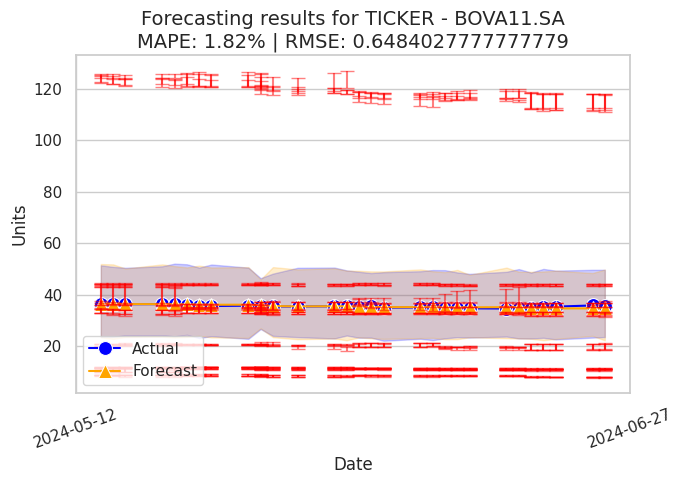

In [11]:
visualize_validation_results(validation_report_df, ticker_list[0])

## Analysing overfitting

In [50]:
feature_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, PROCESSED_DATA_NAME), parse_dates=["DATE"])
feature_df = feature_df[feature_df[CATEGORY_COL].isin(ticker_list)]

In [51]:
X, y = split_feat_df_Xy(feature_df)

In [52]:
predictions_df, X_testing_df = stepwise_prediction(
    X=feature_df.drop(columns=[TARGET_COL, CATEGORY_COL]),
    y=feature_df[TARGET_COL],
    forecast_horizon=FORECAST_HORIZON,
    model_type=models_list[0],
    ticker=ticker_list[0],
    load_best_params=True
)

[0]	validation_0-rmse:28.62312	validation_0-logloss:-1087.89940
[20]	validation_0-rmse:3.56839	validation_0-logloss:-1097.83053
[34]	validation_0-rmse:0.98756	validation_0-logloss:-1097.99476


In [53]:
predictions_df

,DATE,ACTUAL,FORECAST,MAPE,MAE,WAPE,RMSE,MODEL_TYPE,CLASS,TRAINING_MAPE,TRAINING_RMSE
0,2024-06-17,10.82,11.241820,0.0801,0.88,0.08,0.96,XGBRegressor,Testing,0.0376,0.99
1,2024-06-18,10.90,11.546720,0.0801,0.88,0.08,0.96,XGBRegressor,Testing,0.0376,0.99
2,2024-06-19,11.03,11.822775,0.0801,0.88,0.08,0.96,XGBRegressor,Testing,0.0376,0.99
3,2024-06-20,11.13,12.129062,0.0801,0.88,0.08,0.96,XGBRegressor,Testing,0.0376,0.99
4,2024-06-21,10.92,12.455792,0.0801,0.88,0.08,0.96,XGBRegressor,Testing,0.0376,0.99


In [57]:
predictions_df["MAPE"].mean() / predictions_df["TRAINING_MAPE"].mean()
# O MAPE de teste foi o dobro do treinamento

2.13031914893617